In [1]:
from models import *
from utils import set_seed
from data.loaders import *
from utils import *

In [2]:
user = 'ajimenez'
path_to_model = f"/home/{user}/CoSE-pytorch/wandb/latest-run/files/hsj69u4t_weights_trained/epoch_200"

In [3]:
config = configure_model('config.json', False)

In [4]:
set_seed(0)
device = torch.device('cuda:2')
cose = CoSEModel(config, False)
cose.encoder.load_state_dict(torch.load(os.path.join(os.getcwd(), path_to_model,"encoder.pth"), map_location=device))
cose.decoder.load_state_dict(torch.load(os.path.join(os.getcwd(),path_to_model ,"decoder.pth"), map_location=device))
cose.position_predictive_model.load_state_dict(torch.load(os.path.join(os.getcwd(),path_to_model,"pos_pred.pth"), map_location=device))
cose.embedding_predictive_model.load_state_dict(torch.load(os.path.join(os.getcwd(),path_to_model,"emb_pred.pth"), map_location=device))

<All keys matched successfully>

In [5]:
#optimizer_ae, optimizer_pos_pred, optimizer_emb_pred 
optimizers = cose.init_optimizers()


train_loader = get_batch_iterator(cose.config.train_dataset_path)

log_dir = f'/home/ajimenez/pruebas'

In [6]:
mean_channel, std_channel = get_stats(cose.config.stats_path)

In [7]:
for batch_input, batch_target in iter(train_loader):
    break

In [8]:
enc_inputs, t_inputs, stroke_len_inputs, inputs_start_coord, inputs_end_coord, num_strokes_x_diagram_tensor = parse_inputs(batch_input,cose.device)
t_target_ink = parse_targets(batch_target,cose.device)

In [9]:
comb_mask , look_ahead_mask, _ = generate_3d_mask(enc_inputs, stroke_len_inputs, cose.device, cose.config.enc_nhead)
encoder_out = cose.encoder(enc_inputs.permute(1,0,2), stroke_len_inputs, comb_mask)
encoder_out_reshaped = encoder_out.unsqueeze(dim=1).repeat(1,t_inputs.shape[1],1).reshape(-1, encoder_out.shape[-1])
t_inputs_reshaped = t_inputs.reshape(-1,1)
decoder_inp = torch.cat([encoder_out_reshaped, t_inputs_reshaped], dim = 1)
strokes_out, ae_mu, ae_sigma, ae_pi= cose.decoder(decoder_inp)

In [50]:
diagram_embedding, padded_max_num_strokes, min_n_stroke, num_diagrams = reshape_stroke2diagram(encoder_out,num_strokes_x_diagram_tensor)
start_pos_base = inputs_start_coord.reshape(num_diagrams,padded_max_num_strokes,2)

In [53]:
num_predictive_inputs = 32
num_predictive_inputs //= 2
#creates indexes to gather from 
# -----------------------#
all_input_emb = []
all_input_start_pos = []
all_seq_len_emb = []
#-----------------------#
all_target_emb = []
all_target_start_pos = []
all_n_inputs = []

In [58]:
input_indexes, target_indexes, n_inputs = get_random_inp_target_pairs(num_strokes_x_diagram_tensor,
                                                                      padded_max_num_strokes,
                                                                      num_diagrams,
                                                                      min_n_stroke, device)

In [61]:
n_inputs = torch.randint(2, min_n_stroke,size = (1,)).to(device).item() #validated with tf
target_indexes = (torch.rand([num_diagrams]).to(device)*(num_strokes_x_diagram_tensor - 1)).int() #validated with tf
input_range = torch.arange(start=0, end = padded_max_num_strokes).repeat(num_diagrams,1).to(device) #validated with tf

In [69]:
target_indexes

tensor([5, 3, 2, 0, 6, 6, 6, 3, 5, 3, 5, 5, 0, 4, 7, 1, 0, 2, 5, 0, 4, 2, 0, 5,
        2, 1, 0, 4, 5, 2, 1, 9], device='cuda:2', dtype=torch.int32)

In [72]:
num_strokes_x_diagram_tensor

tensor([ 9,  9,  9,  8, 12,  9, 10, 11,  9, 10,  9,  9,  9,  8, 10,  9, 12,  9,
        11, 11,  9, 10, 11, 11, 12, 12, 10, 10, 10,  8,  9, 11],
       device='cuda:2', dtype=torch.int32)

In [70]:
mask = ((input_range)< num_strokes_x_diagram_tensor.reshape(-1,1)) & ((input_range) != target_indexes.reshape(-1,1)) #validated with tf

In [73]:
input_indexes = torch.multinomial((input_range*mask).float().to(device),n_inputs) #validated with tf

In [85]:
assert (input_indexes==target_indexes.unsqueeze(dim=1).repeat(1,input_indexes.size(1))).sum() == 0

In [60]:
target_indexes

tensor([ 3,  2,  7,  1,  7,  3,  8,  7,  6,  8,  6,  3,  0,  2,  6,  2,  7,  5,
         3,  4,  5,  0,  7,  1,  5, 10,  3,  7,  8,  5,  4,  1],
       device='cuda:2', dtype=torch.int32)

In [10]:
sampled_input_start_pos, sampled_input_emb,sampled_seq_len_emb,sampled_target_start_pos,sampled_target_emb = random_index_sampling(encoder_out = encoder_out, inputs_start_coord = inputs_start_coord,
                                                                                                                                inputs_end_coord = inputs_end_coord, num_strokes_x_diagram_tensor = num_strokes_x_diagram_tensor,
                                                                                                                                input_type =cose.config.input_type, num_predictive_inputs = 32,
                                                                                                                                replace_padding = True, end_positions = False, device = cose.device)

# Base

In [12]:
emb_ = sampled_input_emb[0][:sampled_seq_len_emb[0].int()].to(cose.device)
base_batch_start_pos = sampled_input_start_pos[0][:sampled_seq_len_emb[0].int()].to(cose.device)
base_draw_seq_len = np.array([50]*(emb_.size(0)))
base_batch_stroke = decode_sequence(cose.decoder, emb_, base_draw_seq_len, cose.device)

In [48]:
base_batch_start_pos[0]

tensor([-1.4441,  0.6522], device='cuda:2')

In [49]:
predicted_batch_start_pos

tensor([[-1.4441,  0.6522]], device='cuda:2')

## Prediction

In [13]:
emb_ = sampled_target_emb[0].unsqueeze(dim=0).to(cose.device)
predicted_batch_start_pos = sampled_target_start_pos[0].unsqueeze(dim=0).to(cose.device)
predicted_draw_seq_len = np.array([50]*(emb_.size(0)))
predicted_batch_stroke = decode_sequence(cose.decoder, emb_, predicted_draw_seq_len, cose.device)

In [47]:
emb_

tensor([[-0.0540, -0.1145,  0.3958, -1.4364, -0.5806,  0.1631, -2.2795, -0.0087]],
       device='cuda:2', grad_fn=<UnsqueezeBackward0>)

In [40]:
batch_start_pos = torch.vstack([base_batch_start_pos,predicted_batch_start_pos])
batch_stroke = torch.vstack([base_batch_stroke,predicted_batch_stroke])
draw_seq_len = np.append(base_draw_seq_len, predicted_draw_seq_len)

In [46]:
emb_[0], 

tensor([-0.0540, -0.1145,  0.3958, -1.4364, -0.5806,  0.1631, -2.2795, -0.0087],
       device='cuda:2', grad_fn=<SelectBackward>)

In [41]:
batch_start_pos.shape, batch_stroke.shape, draw_seq_len.shape

(torch.Size([8, 2]), torch.Size([8, 50, 2]), (8,))

In [16]:
predicted_batch_stroke.shape

torch.Size([1, 50, 2])

In [17]:
base_batch_stroke.shape

torch.Size([7, 50, 2])

In [18]:
base_batch_start_pos.shape

torch.Size([7, 2])

In [19]:
log_dir = f'/home/ajimenez/pruebas'

In [44]:
npfig, fig, _, _ = transform_strokes_to_image(base_batch_stroke.detach().cpu(), base_draw_seq_len, base_batch_start_pos.detach().cpu(), mean_channel,
                               std_channel, num_strokes=base_batch_stroke.shape[0], stroke_pred=None, start_coord_pred=None, output_path = log_dir, output_file = 'noutput_pruebas',  save  = True, square_figure=True, alpha=0.5, highlight_start=True)

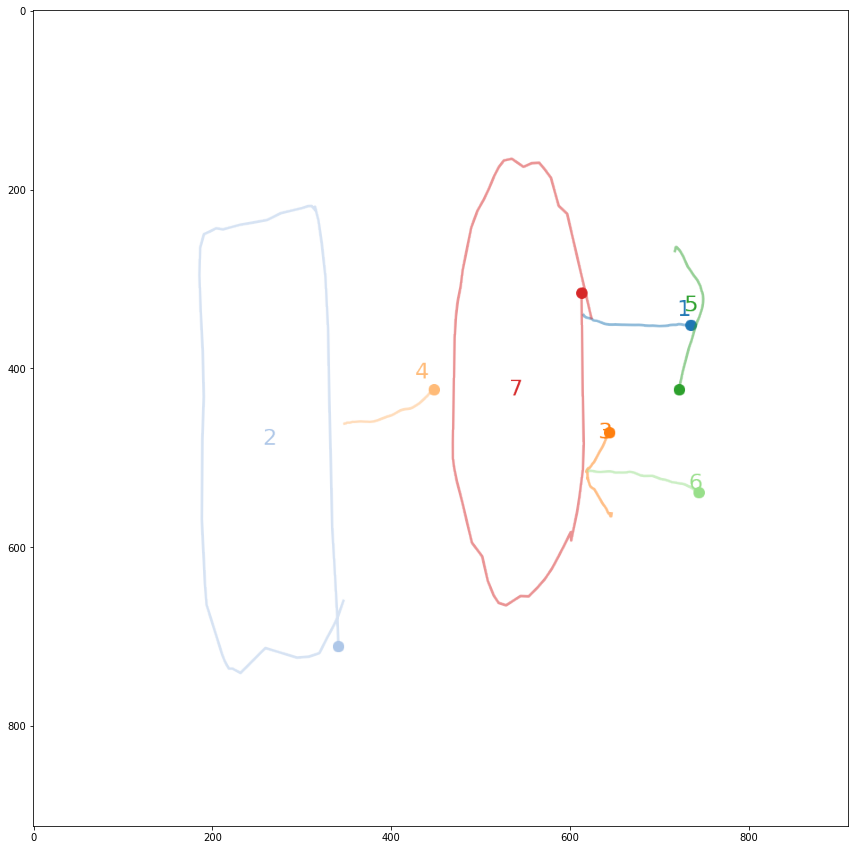

In [45]:
plt.figure(figsize = (15,15))
plt.imshow(npfig)

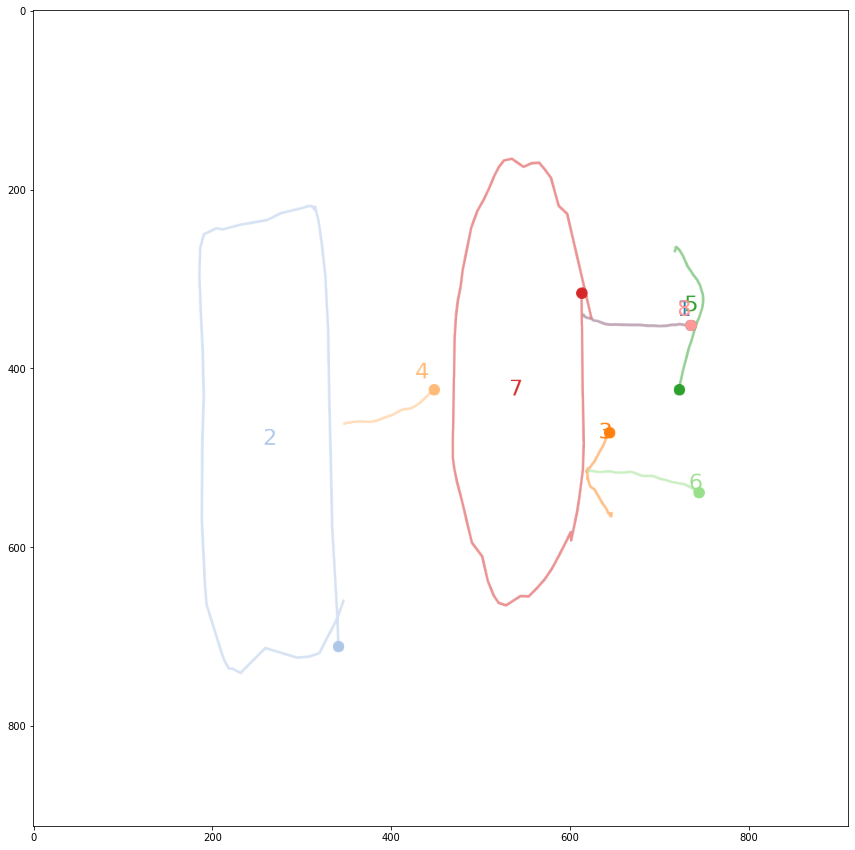

In [43]:
plt.figure(figsize = (15,15))
plt.imshow(npfig)

In [29]:
emb_.shape

torch.Size([7, 8])

In [17]:
sampled_target_emb.shape

torch.Size([1024, 8])

In [16]:
sampled_target_start_pos.shape

torch.Size([1024, 2])

In [18]:
sampled_seq_len_emb

tensor([7., 7., 7.,  ..., 5., 5., 5.])

In [13]:
sampled_input_start_pos.shape

torch.Size([1024, 7, 2])

In [14]:
sampled_input_emb.shape

torch.Size([1024, 7, 8])